In [1]:
import time
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, Nadam, SGD
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras import losses

print(tf.__version__)    #YOUR TF VERSION CHECK

2.9.0


In [2]:
# Define the image size and number of classes
img_size = 64
num_classes = 200

# Create the data generators for training and validation sets
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
)

train_generator = train_datagen.flow_from_directory(
    'tiny-imagenet-200/train',
    target_size=(img_size, img_size),
    batch_size=64,
    class_mode='categorical'
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
)

val_generator = val_datagen.flow_from_directory(
    'tiny-imagenet-200/val',
    target_size=(img_size, img_size),
    batch_size=64,
    class_mode='categorical'
)

Found 100000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.


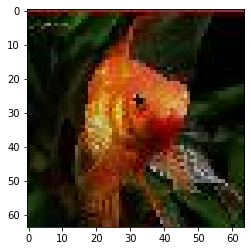

In [3]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

#Displaying a sample train image of Fish category
image = Image.open('tiny-imagenet-200/train/n01443537/images/n01443537_4.JPEG')
image_array = np.asarray(image)

plt.imshow(image_array)
plt.show()

#### As we can see the image is only of 64X64X3 size and is highly blured. Classification can be performed but expecting high validation accuracy can be challenging.

In [4]:
#Below class is to record the model training times
class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []
        
    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()
        
    def on_epoch_end(self, batch, logs={}):
        epoch_time_end = time.time()
        self.times.append(epoch_time_end - self.epoch_time_start)

# DEEP CNN Models

## 1. Single Convolutional Layer NN model

In [5]:
# Define the CNN architecture
model1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [6]:
print(model1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 30752)             0         
                                                                 
 dense (Dense)               (None, 1024)              31491072  
                                                                 
 dense_1 (Dense)             (None, 200)               205000    
                                                                 
Total params: 31,696,968
Trainable params: 31,696,968
Non-trainable params: 0
____________________________________________

In [7]:
time_callback = TimeHistory()

# Compile the model with an optimizer, a loss function, and evaluation metrics
model1.compile(optimizer=Adam(learning_rate = 0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model on the training data and validate it on the validation data
with tf.device('/device:GPU:0'):
    history = model1.fit(train_generator,
                        validation_data=val_generator,
                        epochs=15,
                        callbacks=[time_callback, tf.keras.callbacks.TensorBoard(log_dir='./logs')])

Epoch 1/15
1563/1563 [==============================] - 38s 24ms/step - loss: 4.7895 - accuracy: 0.0600 - val_loss: 4.4842 - val_accuracy: 0.0993
Epoch 2/15
1563/1563 [==============================] - 36s 23ms/step - loss: 4.3215 - accuracy: 0.1191 - val_loss: 4.2536 - val_accuracy: 0.1265
Epoch 3/15
1563/1563 [==============================] - 36s 23ms/step - loss: 4.0804 - accuracy: 0.1529 - val_loss: 4.1041 - val_accuracy: 0.1457
Epoch 4/15
1563/1563 [==============================] - 36s 23ms/step - loss: 3.8904 - accuracy: 0.1814 - val_loss: 3.9833 - val_accuracy: 0.1618
Epoch 5/15
1563/1563 [==============================] - 36s 23ms/step - loss: 3.7341 - accuracy: 0.2067 - val_loss: 3.8976 - val_accuracy: 0.1720
Epoch 6/15
1563/1563 [==============================] - 36s 23ms/step - loss: 3.5990 - accuracy: 0.2288 - val_loss: 3.8270 - val_accuracy: 0.1868
Epoch 7/15
1563/1563 [==============================] - 36s 23ms/step - loss: 3.4708 - accuracy: 0.2517 - val_loss: 3.7874 -

In [8]:
total_time = sum(time_callback.times)
print(f"Total execution time: {total_time:.2f} seconds")

Total execution time: 552.10 seconds


## 2. Two Convolutional Layer NN model


In [9]:
# Define the CNN architecture
model2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [10]:
print(model2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 12544)             0         
                                                                 
 dense_2 (Dense)             (None, 1024)             

In [11]:
time_callback = TimeHistory()

# Compile the model with an optimizer, a loss function, and evaluation metrics
model2.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model on the training data and validate it on the validation data
with tf.device('/device:GPU:0'):
    history = model2.fit(train_generator,
                        validation_data=val_generator,
                        epochs=15,
                        callbacks=[time_callback, tf.keras.callbacks.TensorBoard(log_dir='./logs')])

Epoch 1/15
1563/1563 [==============================] - 31s 20ms/step - loss: 4.9267 - accuracy: 0.0650 - val_loss: 4.5511 - val_accuracy: 0.1037
Epoch 2/15
1563/1563 [==============================] - 34s 22ms/step - loss: 4.3696 - accuracy: 0.1274 - val_loss: 4.2424 - val_accuracy: 0.1458
Epoch 3/15
1563/1563 [==============================] - 32s 21ms/step - loss: 4.0945 - accuracy: 0.1645 - val_loss: 4.0543 - val_accuracy: 0.1671
Epoch 4/15
1563/1563 [==============================] - 31s 20ms/step - loss: 3.8943 - accuracy: 0.1944 - val_loss: 3.9258 - val_accuracy: 0.1874
Epoch 5/15
1563/1563 [==============================] - 31s 20ms/step - loss: 3.7441 - accuracy: 0.2176 - val_loss: 3.8419 - val_accuracy: 0.1994
Epoch 6/15
1563/1563 [==============================] - 33s 21ms/step - loss: 3.6196 - accuracy: 0.2376 - val_loss: 3.7395 - val_accuracy: 0.2154
Epoch 7/15
1563/1563 [==============================] - 33s 21ms/step - loss: 3.5122 - accuracy: 0.2550 - val_loss: 3.6906 -

In [12]:
total_time = sum(time_callback.times)
print(f"Total execution time: {total_time:.2f} seconds")

Total execution time: 478.81 seconds


## 3. DEEP CNN Model 1

In [13]:
model3 = Sequential()

model3.add(Conv2D(64, (3, 3), strides=(1,1), padding='same', input_shape=(img_size, img_size, 3)))
model3.add(BatchNormalization())
model3.add(Conv2D(64, (3, 3), strides=(1,1), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))
model3.add(Activation('relu'))

model3.add(Conv2D(128, (3, 3), strides=(1,1), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model3.add(BatchNormalization())
model3.add(Conv2D(128, (3, 3), strides=(1,1), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))
model3.add(Activation('relu'))

model3.add(Conv2D(128, (3, 3), strides=(1,1), padding='same', kernel_regularizer=regularizers.l2(0.001)))
model3.add(BatchNormalization())
model3.add(Conv2D(128, (3, 3), strides=(1,1), padding='same', kernel_regularizer=regularizers.l2(0.001)))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))

model3.add(Conv2D(128, (3, 3), strides=(1,1), padding='same', kernel_regularizer=regularizers.l2(0.001)))
model3.add(BatchNormalization())
model3.add(Conv2D(128, (3, 3), strides=(1,1), padding='same', kernel_regularizer=regularizers.l2(0.001)))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))

model3.add(Conv2D(256, (3, 3), strides=(1,1), padding='same', kernel_regularizer=regularizers.l2(0.001)))
model3.add(BatchNormalization())
model3.add(Conv2D(512, (3, 3), strides=(1,1), padding='same', kernel_regularizer=regularizers.l2(0.001)))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))

model3.add(Flatten())
model3.add(Dense(4096))
model3.add(BatchNormalization())
model3.add(Activation('relu'))

model3.add(Dense(1024))
model3.add(BatchNormalization())
model3.add(Activation('relu'))

model3.add(Dense(num_classes))

model3.add(Activation('softmax'))

time_callback = TimeHistory()

model3.compile(loss=losses.categorical_crossentropy, 
optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

In [14]:
print(model3.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        1792      
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                      

In [15]:
# Train the model on the training data and validate it on the validation data
with tf.device('/device:GPU:0'):
    history = model3.fit(train_generator,
                        validation_data=val_generator,
                        epochs=15,
                        callbacks=[time_callback, tf.keras.callbacks.TensorBoard(log_dir='./logs')])

Epoch 1/15
1563/1563 [==============================] - 197s 125ms/step - loss: 7.1246 - accuracy: 0.1654 - val_loss: 6.1606 - val_accuracy: 0.2170
Epoch 2/15
1563/1563 [==============================] - 196s 125ms/step - loss: 5.3315 - accuracy: 0.2849 - val_loss: 4.9999 - val_accuracy: 0.2842
Epoch 3/15
1563/1563 [==============================] - 196s 125ms/step - loss: 4.3545 - accuracy: 0.3569 - val_loss: 4.3981 - val_accuracy: 0.3104
Epoch 4/15
1563/1563 [==============================] - 196s 125ms/step - loss: 3.7288 - accuracy: 0.4108 - val_loss: 4.1502 - val_accuracy: 0.3201
Epoch 5/15
1563/1563 [==============================] - 196s 125ms/step - loss: 3.2835 - accuracy: 0.4561 - val_loss: 3.6812 - val_accuracy: 0.3706
Epoch 6/15
1563/1563 [==============================] - 196s 125ms/step - loss: 2.9388 - accuracy: 0.4983 - val_loss: 3.4901 - val_accuracy: 0.3859
Epoch 7/15
1563/1563 [==============================] - 196s 125ms/step - loss: 2.6481 - accuracy: 0.5429 - val_

In [16]:
total_time = sum(time_callback.times)
print(f"Total execution time: {total_time:.2f} seconds")

Total execution time: 3054.00 seconds


## 4. Deep CNN Model 2

In [17]:
# Import required libraries
import tensorflow as tf
from tensorflow.keras import layers

# Define the input shape
input_shape = (64, 64, 3)

# Define the model layers
model4 = tf.keras.Sequential([
    layers.Conv2D(64, (3,3), padding='same', activation='relu', input_shape=input_shape),
    layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.MaxPooling2D((2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(128, (3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.MaxPooling2D((2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(256, (3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Conv2D(256, (3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),

    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5), 
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(200, activation='softmax')
])

time_callback = TimeHistory()

# Compile the model
model4.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [18]:
# Print the model summary
print(model4.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 64, 64, 64)        1792      
                                                                 
 conv2d_14 (Conv2D)          (None, 64, 64, 64)        36928     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_12 (Bat  (None, 32, 32, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_15 (Conv2D)          (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 16, 16, 128)     

In [19]:
# Train the model
with tf.device('/device:GPU:0'):
    history = model4.fit(train_generator,
                        epochs=25,
                        validation_data=val_generator,
                        callbacks=[time_callback, tf.keras.callbacks.TensorBoard(log_dir='./logs')])

Epoch 1/25
1563/1563 [==============================] - 151s 96ms/step - loss: 7.1938 - accuracy: 0.0339 - val_loss: 5.0122 - val_accuracy: 0.1006
Epoch 2/25
1563/1563 [==============================] - 150s 96ms/step - loss: 4.6325 - accuracy: 0.1095 - val_loss: 4.0970 - val_accuracy: 0.1766
Epoch 3/25
1563/1563 [==============================] - 149s 96ms/step - loss: 4.0229 - accuracy: 0.1744 - val_loss: 3.6336 - val_accuracy: 0.2409
Epoch 4/25
1563/1563 [==============================] - 149s 96ms/step - loss: 3.6961 - accuracy: 0.2189 - val_loss: 3.4759 - val_accuracy: 0.2642
Epoch 5/25
1563/1563 [==============================] - 149s 96ms/step - loss: 3.4683 - accuracy: 0.2555 - val_loss: 3.2908 - val_accuracy: 0.2893
Epoch 6/25
1563/1563 [==============================] - 150s 96ms/step - loss: 3.2929 - accuracy: 0.2885 - val_loss: 3.1674 - val_accuracy: 0.3149
Epoch 7/25
1563/1563 [==============================] - 150s 96ms/step - loss: 3.1501 - accuracy: 0.3148 - val_loss: 3

In [20]:
total_time = sum(time_callback.times)
print(f"Total execution time: {total_time:.2f} seconds")

Total execution time: 3744.04 seconds


## 5) ResNet Model 1- ResNet50 

In [5]:
resnet50_model = tf.keras.applications.ResNet50(
    weights='imagenet', 
    include_top=False, 
    input_shape=(img_size, img_size, 3)
)

In [6]:
x = resnet50_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(num_classes, activation='softmax')(x)

model5 = models.Model(inputs = resnet50_model.input, outputs=predictions)

In [7]:
time_callback = TimeHistory()

# Compile the model
model5.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [8]:
print(model5.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1_conv[0][0]']             
                                                                                              

                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 16, 16, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 16, 16, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 16, 16, 256)  16640       ['conv2_block3_2_relu[0][0]']    
                                                                                                  
 conv2_block3_3_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv2_block3_3_conv[0][0]']    
 ization) 

                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 8, 8, 128)   512         ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 8, 8, 128)   0           ['conv3_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_3_conv (Conv2D)   (None, 8, 8, 512)    66048       ['conv3_block3_2_relu[0][0]']    
                                                                                                  
 conv3_block3_3_bn (BatchNormal  (None, 8, 8, 512)   2048        ['conv3_block3_3_conv[0][0]']    
 ization) 

                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 4, 4, 256)   1024        ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_2_relu (Activatio  (None, 4, 4, 256)   0           ['conv4_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_3_conv (Conv2D)   (None, 4, 4, 1024)   263168      ['conv4_block2_2_relu[0][0]']    
                                                                                                  
 conv4_block2_3_bn (BatchNormal  (None, 4, 4, 1024)  4096        ['conv4_block2_3_conv[0][0]']    
 ization) 

 n)                                                                                               
                                                                                                  
 conv4_block5_3_conv (Conv2D)   (None, 4, 4, 1024)   263168      ['conv4_block5_2_relu[0][0]']    
                                                                                                  
 conv4_block5_3_bn (BatchNormal  (None, 4, 4, 1024)  4096        ['conv4_block5_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_add (Add)         (None, 4, 4, 1024)   0           ['conv4_block4_out[0][0]',       
                                                                  'conv4_block5_3_bn[0][0]']      
                                                                                                  
 conv4_blo

 n)                                                                                               
                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 2, 2, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, 2, 2, 2048)  8192        ['conv5_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_add (Add)         (None, 2, 2, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_bn[0][0]']      
                                                                                                  
 conv5_blo

In [9]:
# Train the model
with tf.device('/device:GPU:0'):
    history = model5.fit(train_generator,
                        epochs=15,
                        validation_data=val_generator,
                        callbacks=[time_callback, tf.keras.callbacks.TensorBoard(log_dir='./logs')])

Epoch 1/15
1563/1563 [==============================] - 228s 143ms/step - loss: 3.4713 - accuracy: 0.2689 - val_loss: 2.3051 - val_accuracy: 0.4529
Epoch 2/15
1563/1563 [==============================] - 222s 142ms/step - loss: 2.1666 - accuracy: 0.4841 - val_loss: 2.0099 - val_accuracy: 0.5088
Epoch 3/15
1563/1563 [==============================] - 221s 141ms/step - loss: 1.7259 - accuracy: 0.5727 - val_loss: 1.9419 - val_accuracy: 0.5334
Epoch 4/15
1563/1563 [==============================] - 219s 140ms/step - loss: 1.4161 - accuracy: 0.6404 - val_loss: 1.9479 - val_accuracy: 0.5355
Epoch 5/15
1563/1563 [==============================] - 220s 140ms/step - loss: 1.1795 - accuracy: 0.6917 - val_loss: 1.8960 - val_accuracy: 0.5548
Epoch 6/15
1563/1563 [==============================] - 220s 141ms/step - loss: 0.9778 - accuracy: 0.7399 - val_loss: 1.9514 - val_accuracy: 0.5486
Epoch 7/15
1563/1563 [==============================] - 220s 141ms/step - loss: 0.8171 - accuracy: 0.7795 - val_

In [10]:
total_time = sum(time_callback.times)
print(f"Total execution time: {total_time:.2f} seconds")

Total execution time: 3320.05 seconds


## 6) ResNet Model 2 - ResNet101

In [11]:
resnet101_model = tf.keras.applications.ResNet101(
    include_top=False,
    weights="imagenet",
    input_shape=(img_size, img_size, 3),
)

In [12]:
x = resnet101_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(num_classes, activation='softmax')(x)

model6 = models.Model(inputs = resnet101_model.input, outputs=predictions)

In [13]:
time_callback = TimeHistory()

# Compile the model
model6.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
print(model6.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1_conv[0][0]']             
                                                                                            

                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 16, 16, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 16, 16, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 16, 16, 256)  16640       ['conv2_block3_2_relu[0][0]']    
                                                                                                  
 conv2_block3_3_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv2_block3_3_conv[0][0]']    
 ization) 

                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 8, 8, 128)   512         ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 8, 8, 128)   0           ['conv3_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_3_conv (Conv2D)   (None, 8, 8, 512)    66048       ['conv3_block3_2_relu[0][0]']    
                                                                                                  
 conv3_block3_3_bn (BatchNormal  (None, 8, 8, 512)   2048        ['conv3_block3_3_conv[0][0]']    
 ization) 

                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 4, 4, 256)   1024        ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_2_relu (Activatio  (None, 4, 4, 256)   0           ['conv4_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_3_conv (Conv2D)   (None, 4, 4, 1024)   263168      ['conv4_block2_2_relu[0][0]']    
                                                                                                  
 conv4_block2_3_bn (BatchNormal  (None, 4, 4, 1024)  4096        ['conv4_block2_3_conv[0][0]']    
 ization) 

 n)                                                                                               
                                                                                                  
 conv4_block5_3_conv (Conv2D)   (None, 4, 4, 1024)   263168      ['conv4_block5_2_relu[0][0]']    
                                                                                                  
 conv4_block5_3_bn (BatchNormal  (None, 4, 4, 1024)  4096        ['conv4_block5_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_add (Add)         (None, 4, 4, 1024)   0           ['conv4_block4_out[0][0]',       
                                                                  'conv4_block5_3_bn[0][0]']      
                                                                                                  
 conv4_blo

 ization)                                                                                         
                                                                                                  
 conv4_block8_add (Add)         (None, 4, 4, 1024)   0           ['conv4_block7_out[0][0]',       
                                                                  'conv4_block8_3_bn[0][0]']      
                                                                                                  
 conv4_block8_out (Activation)  (None, 4, 4, 1024)   0           ['conv4_block8_add[0][0]']       
                                                                                                  
 conv4_block9_1_conv (Conv2D)   (None, 4, 4, 256)    262400      ['conv4_block8_out[0][0]']       
                                                                                                  
 conv4_block9_1_bn (BatchNormal  (None, 4, 4, 256)   1024        ['conv4_block9_1_conv[0][0]']    
 ization) 

 conv4_block11_out (Activation)  (None, 4, 4, 1024)  0           ['conv4_block11_add[0][0]']      
                                                                                                  
 conv4_block12_1_conv (Conv2D)  (None, 4, 4, 256)    262400      ['conv4_block11_out[0][0]']      
                                                                                                  
 conv4_block12_1_bn (BatchNorma  (None, 4, 4, 256)   1024        ['conv4_block12_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block12_1_relu (Activati  (None, 4, 4, 256)   0           ['conv4_block12_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_blo

 lization)                                                                                        
                                                                                                  
 conv4_block15_1_relu (Activati  (None, 4, 4, 256)   0           ['conv4_block15_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block15_2_conv (Conv2D)  (None, 4, 4, 256)    590080      ['conv4_block15_1_relu[0][0]']   
                                                                                                  
 conv4_block15_2_bn (BatchNorma  (None, 4, 4, 256)   1024        ['conv4_block15_2_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_blo

 conv4_block18_2_conv (Conv2D)  (None, 4, 4, 256)    590080      ['conv4_block18_1_relu[0][0]']   
                                                                                                  
 conv4_block18_2_bn (BatchNorma  (None, 4, 4, 256)   1024        ['conv4_block18_2_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block18_2_relu (Activati  (None, 4, 4, 256)   0           ['conv4_block18_2_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block18_3_conv (Conv2D)  (None, 4, 4, 1024)   263168      ['conv4_block18_2_relu[0][0]']   
                                                                                                  
 conv4_blo

 conv4_block21_2_relu (Activati  (None, 4, 4, 256)   0           ['conv4_block21_2_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block21_3_conv (Conv2D)  (None, 4, 4, 1024)   263168      ['conv4_block21_2_relu[0][0]']   
                                                                                                  
 conv4_block21_3_bn (BatchNorma  (None, 4, 4, 1024)  4096        ['conv4_block21_3_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block21_add (Add)        (None, 4, 4, 1024)   0           ['conv4_block20_out[0][0]',      
                                                                  'conv4_block21_3_bn[0][0]']     
          

 conv5_block1_3_conv (Conv2D)   (None, 2, 2, 2048)   1050624     ['conv5_block1_2_relu[0][0]']    
                                                                                                  
 conv5_block1_0_bn (BatchNormal  (None, 2, 2, 2048)  8192        ['conv5_block1_0_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block1_3_bn (BatchNormal  (None, 2, 2, 2048)  8192        ['conv5_block1_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block1_add (Add)         (None, 2, 2, 2048)   0           ['conv5_block1_0_bn[0][0]',      
                                                                  'conv5_block1_3_bn[0][0]']      
          

In [15]:
# Train the model
with tf.device('/device:GPU:0'):
    history = model6.fit(train_generator,
                        epochs=15,
                        validation_data=val_generator,
                        callbacks=[time_callback, tf.keras.callbacks.TensorBoard(log_dir='./logs')])

Epoch 1/15
1563/1563 [==============================] - 381s 237ms/step - loss: 3.4322 - accuracy: 0.2747 - val_loss: 2.2370 - val_accuracy: 0.4663
Epoch 2/15
1563/1563 [==============================] - 365s 233ms/step - loss: 2.0805 - accuracy: 0.5015 - val_loss: 2.0029 - val_accuracy: 0.5235
Epoch 3/15
1563/1563 [==============================] - 363s 232ms/step - loss: 1.6227 - accuracy: 0.5986 - val_loss: 1.8773 - val_accuracy: 0.5395
Epoch 4/15
1563/1563 [==============================] - 362s 232ms/step - loss: 1.3010 - accuracy: 0.6671 - val_loss: 1.9223 - val_accuracy: 0.5489
Epoch 5/15
1563/1563 [==============================] - 362s 232ms/step - loss: 1.0509 - accuracy: 0.7246 - val_loss: 1.9876 - val_accuracy: 0.5406
Epoch 6/15
1563/1563 [==============================] - 364s 233ms/step - loss: 0.8478 - accuracy: 0.7735 - val_loss: 2.0723 - val_accuracy: 0.5532
Epoch 7/15
1563/1563 [==============================] - 362s 232ms/step - loss: 0.6897 - accuracy: 0.8113 - val_

In [16]:
total_time = sum(time_callback.times)
print(f"Total execution time: {total_time:.2f} seconds")

Total execution time: 5463.40 seconds
